In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import librosa
import librosa.display
import IPython.display
import os

In [9]:
# Data processing & array operations
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Audio processing
import librosa
import librosa.display

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Flatten, Reshape, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import os
from datetime import datetime
from tqdm import tqdm
import IPython.display

In [10]:
# Cell 1: Import required libraries
import os
import numpy as np
import librosa
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from datetime import datetime
import random


In [ ]:
import os
import librosa
import numpy as np
from tqdm import tqdm

def load_audio_files(base_path):
    # Dictionary to store audio data and labels
    data = {
        'features': [],
        'labels': []
    }
    
    # Update label mapping to match the new class structure
    label_map = {
        'aedes aegypti': 0,
        'aedes albopictus': 1, 
        'anopheles arabiensis': 2,
        'anopheles gambiae': 3,
        'culex': 4,
        'noise': 5
    }

    # Loop through each class folder
    for class_name in label_map.keys():
        class_path = os.path.join(base_path, class_name)
        
        # Skip if not a directory
        if not os.path.isdir(class_path):
            print(f"Skipping {class_name} as it is not a directory.")
            continue
            
        # Process all `.wav` files in the folder (no subfolders)
        for file in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
            if file.endswith('.wav'):
                file_path = os.path.join(class_path, file)
                try:
                    # Load audio file
                    audio, sr = librosa.load(file_path, sr=16000)  # Resample to 16kHz
                    
                    # Split audio into 1-second windows with a 250 ms stride
                    window_size = sr  # 1 second
                    stride = int(0.25 * sr)  # 250 ms
                    num_windows = (len(audio) - window_size) // stride + 1
                    
                    for i in range(num_windows):
                        start = i * stride
                        end = start + window_size
                        window = audio[start:end]
                        
                        # Generate spectrogram with specified parameters
                        n_fft = int(0.025 * sr)  # Frame length: 25 ms
                        hop_length = int(0.0125 * sr)  # Frame stride: 12.5 ms
                        S = librosa.stft(window, n_fft=n_fft, hop_length=hop_length)
                        S_db = librosa.amplitude_to_db(abs(S), ref=np.max)
                        
                        # Apply noise filtering
                        S_db = np.where(S_db < -52, -52, S_db)
                        
                        # Flatten the spectrogram
                        S_db_flat = S_db.flatten()
                        
                        # Resize/pad if needed to ensure consistent dimensions
                        target_length = 5135  # Match your original input size
                        if len(S_db_flat) > target_length:
                            S_db_flat = S_db_flat[:target_length]
                        elif len(S_db_flat) < target_length:
                            pad_width = target_length - len(S_db_flat)
                            S_db_flat = np.pad(S_db_flat, (0, pad_width))
                            
                        # Add to dataset
                        data['features'].append(S_db_flat)
                        data['labels'].append(label_map[class_name])
                        
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
                    continue

    # Convert to numpy arrays
    X = np.array(data['features'])
    Y = np.array(data['labels'])
    
    return X, Y

# Use the function
base_path = "./datasets/Abuzz_Preprocessed"  # Updated path to your dataset location
X, Y = load_audio_files(base_path)

# Check the shapes
print("Feature matrix shape:", X.shape)
print("Labels shape:", Y.shape)


Processing noise: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


Feature matrix shape: (33198, 5135)
Labels shape: (33198,)


In [4]:
image = X[10]
img_length = image.shape[0]
img_length

5135

In [5]:
# Set the number of columns
columns = 65
rows = int(img_length / columns)
image = np.reshape(image, (rows, columns))
print(image.shape)  # Output should be (125, 41)

(79, 65)


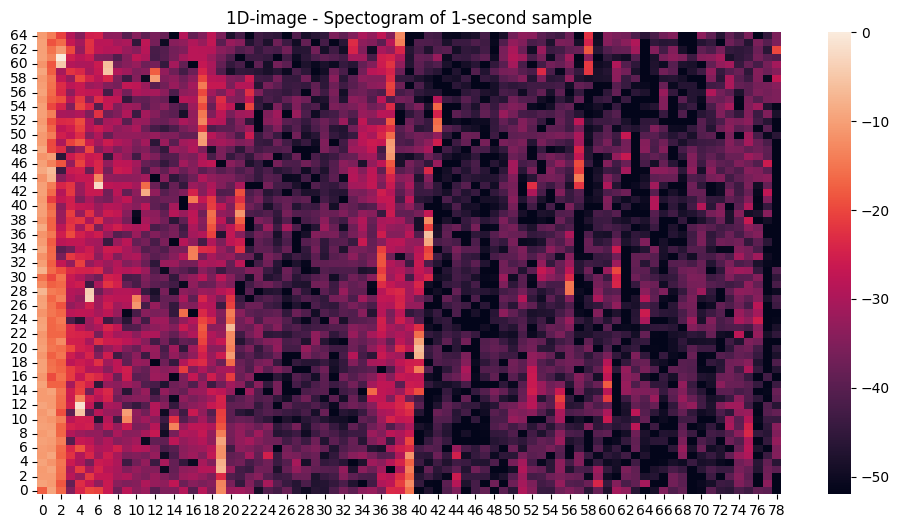

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
#sns.heatmap(image.T)
ax = sns.heatmap(image.T)
ax.invert_yaxis()
plt.title('1D-image - Spectogram of 1-second sample');

In [11]:
# Set random seed for reproducibility
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "aedes aegypti", "aedes albopictus", "anopheles arabiensis", "anopheles gambiae", "culex", "noise" ]
classes = len(classes_values)


# Convert labels to one-hot encoding
Y = tf.keras.utils.to_categorical(Y, classes)

# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Create TensorFlow datasets
# Prepare the data for training
input_length = X_train[0].shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=10)

callbacks = [early_stop]

Train the model:

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam

# model architecture
model = Sequential()
model.add(Reshape((int(input_length / 65), 65), input_shape=(input_length, )))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax', name='y_pred'))
model.summary()

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 79, 65)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 79, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 40, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 40, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ y_pred (Dense)                  │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,166 (78.77 KB)

 Trainable params: 20,166 (78.77 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
LR = 0.001
BS = 32
EPOCHS = 100

In [15]:
# this controls the learning rate
opt = Adam(learning_rate=LR, beta_1=0.9, beta_2=0.999)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = BS
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# train the neural network
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    verbose=2,
                    callbacks=callbacks)

Epoch 1/100
830/830 - 7s - 8ms/step - accuracy: 0.4314 - loss: 1.7876 - val_accuracy: 0.6021 - val_loss: 0.9902
Epoch 2/100
830/830 - 5s - 7ms/step - accuracy: 0.5515 - loss: 1.0707 - val_accuracy: 0.6693 - val_loss: 0.8097
Epoch 3/100
830/830 - 5s - 6ms/step - accuracy: 0.5952 - loss: 0.9782 - val_accuracy: 0.7035 - val_loss: 0.7589
Epoch 4/100
830/830 - 5s - 6ms/step - accuracy: 0.6134 - loss: 0.9329 - val_accuracy: 0.6825 - val_loss: 0.7659
Epoch 5/100
830/830 - 5s - 6ms/step - accuracy: 0.6250 - loss: 0.9129 - val_accuracy: 0.6983 - val_loss: 0.7864
Epoch 6/100
830/830 - 4s - 5ms/step - accuracy: 0.6414 - loss: 0.8812 - val_accuracy: 0.7125 - val_loss: 0.7021
Epoch 7/100
830/830 - 4s - 5ms/step - accuracy: 0.6453 - loss: 0.8657 - val_accuracy: 0.7169 - val_loss: 0.6997
Epoch 8/100
830/830 - 5s - 6ms/step - accuracy: 0.6639 - loss: 0.8275 - val_accuracy: 0.7467 - val_loss: 0.6527
Epoch 9/100
830/830 - 4s - 4ms/step - accuracy: 0.6738 - loss: 0.8129 - val_accuracy: 0.7554 - val_loss:

In [16]:
import matplotlib.pyplot as plt
def plot_result(history, res= 'loss'):
    plt.plot(history.history[res])
    plt.plot(history.history['val_'+res])
    plt.title(res+' vs. epochs')
    plt.ylabel(res)
    plt.xlabel('Epoch')
    if res == 'loss':
        plt.legend(['Training', res], loc='upper right')
    else:
        plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

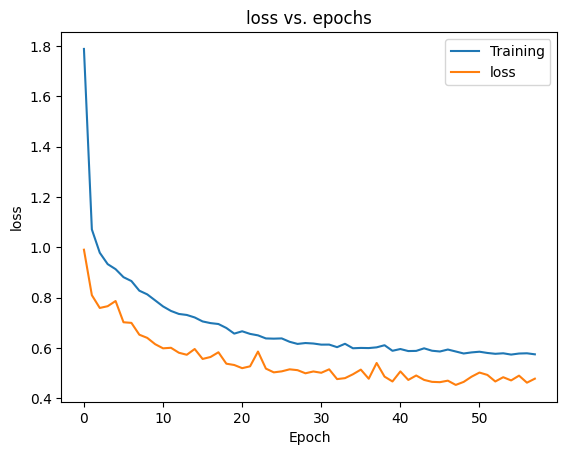

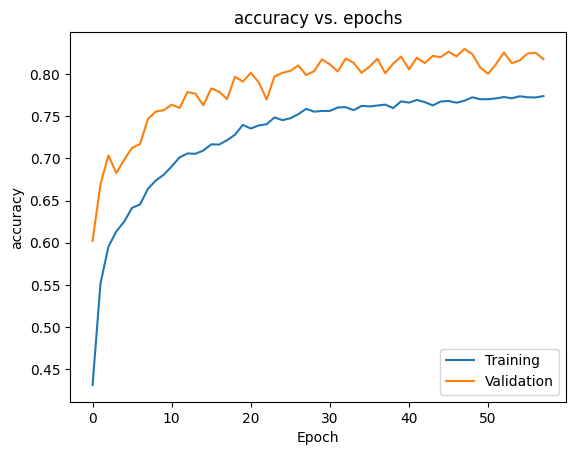

In [17]:
plot_result(history, res= 'loss')
plot_result(history, res= 'accuracy')

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# Assuming X_test and Y_test are your test datasets
# Make predictions
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Calculate precision, recall, and F1 score for each class
precision = precision_score(Y_true, Y_pred_classes, average=None)
recall = recall_score(Y_true, Y_pred_classes, average=None)
f1 = f1_score(Y_true, Y_pred_classes, average=None)
accuracy = accuracy_score(Y_true, Y_pred_classes)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f'Class {i} - Precision: {p:.4f}, Recall: {r:.4f}, F1 Score: {f:.4f}')

# Alternatively, you can use classification_report for a detailed report
print("\nClassification Report:\n")
print(classification_report(Y_true, Y_pred_classes, target_names=['aedes aegypti', 'aedes albopictus', 'anopheles arabiensis', 'anopheles gambiae', 'culex', 'noise']))

208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8176
Class 0 - Precision: 0.7726, Recall: 0.7973, F1 Score: 0.7848
Class 1 - Precision: 0.8588, Recall: 0.6075, F1 Score: 0.7116
Class 2 - Precision: 0.7835, Recall: 0.8209, F1 Score: 0.8018
Class 3 - Precision: 0.7422, Recall: 0.7860, F1 Score: 0.7635
Class 4 - Precision: 0.9924, Recall: 0.9849, F1 Score: 0.9886
Class 5 - Precision: 0.9721, Recall: 0.9812, F1 Score: 0.9767

Classification Report:

                      precision    recall  f1-score   support

       aedes aegypti       0.77      0.80      0.78      1317
    aedes albopictus       0.86      0.61      0.71       721
anopheles arabiensis       0.78      0.82      0.80      1446
   anopheles gambiae       0.74      0.79      0.76      1776
               culex       0.99      0.98      0.99      1060
               noise       0.97      0.98      0.98       320

            accuracy                           0.82      6640
           macro avg       0.85      0.83      

In [22]:
# Save the model to disk in HDF5 format
model.save('saved_model.h5')

In [23]:
# Load the model from the HDF5 file
model = tf.keras.models.load_model('saved_model.h5')

In [24]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to disk
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\nguye\AppData\Local\Temp\tmpovu85feh\assets


INFO:tensorflow:Assets written to: C:\Users\nguye\AppData\Local\Temp\tmpovu85feh\assets


Saved artifact at 'C:\Users\nguye\AppData\Local\Temp\tmpovu85feh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5135), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2562699953936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2562699954320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2562699953552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2562699955088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2562699955472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2562699956816: TensorSpec(shape=(), dtype=tf.resource, name=None)
